In [12]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l1,l1_l2,l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D,MaxPool2D,UpSampling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import he_uniform,he_normal
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight
from shutil import copy2
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import VotingClassifier
import cv2
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
from collections import Counter
import numpy as np
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.utils.multiclass import unique_labels
from tensorflow.keras.models import load_model
# from vis.utils import utils
from tensorflow.keras import activations 
from tensorflow.keras.datasets import cifar10
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tqdm import tqdm

### 1. Dataset Preparation

In [29]:
# num_classes = 15
# img_rows, img_cols = 224,224
img_shape=224,224
batch_size =16
rescale=1./255
# home/kashraf/fall2021_cours
train_data_dir ="/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/train/"
validation_data_dir = "/home/kashraf/fall2021_coursework/Neural Nets/Assignment5/documents_denoising_dataset/document_denoising_dataset/train_cleaned/"
train_names=os.listdir(train_data_dir)
test_names=os.listdir(validation_data_dir)

train=[]
test=[]
for file in train_names:
    img=cv2.imread(train_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    train.append(img)
for file in test_names:
    img=cv2.imread(validation_data_dir+file)
    img=cv2.resize(img, img_shape)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test.append(img)
x_train=np.array(train)
x_test=np.array(test)

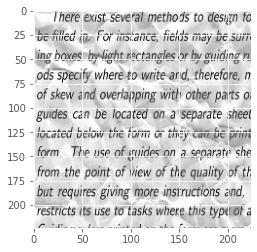

In [30]:
plt.imshow(x_train[0],cmap="gray")

In [22]:
x_train[0].shape

(64, 64)

In [31]:
x_train=x_train
x_test=x_test
x_train = x_train.reshape(-1, img_shape[0],img_shape[0], 1)
x_test = x_test.reshape(-1, img_shape[0],img_shape[0], 1)
print("Train shape: ",x_train.shape)
print("Test shape: ",x_test.shape)

Train shape:  (144, 224, 224, 1)
Test shape:  (144, 224, 224, 1)


### 2. Designing the network

In [32]:
# input layer
input_layer = tensorflow.keras.Input(shape=(img_shape[0], img_shape[0], 1))

# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPool2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPool2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPool2D( (2, 2), padding='same')(encoded_layer3)
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3),activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), padding='same',activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
# compile the model
model = Model(input_layer, output_layer)
model.compile(optimizer='adam', loss='mse')
print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 56, 56, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 16)        0   

### Training

In [48]:
checkpoint = ModelCheckpoint("AE_doc_denoise.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 10,
                          verbose = 5,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 3,
                              verbose = 1,
                              min_delta = 0.0001)

# we put our call backs into a callback list
callbacks = [ checkpoint,earlystop, reduce_lr]

# We use a very small learning rate 
epochs = 300

history= model.fit(x=x_train,y=x_train,
    epochs = epochs,
    batch_size=1,
    validation_data=(x_test,x_test)
                  )


Epoch 1/300
144/144 [==============================] - 1s 4ms/step - loss: 1155.9570 - val_loss: 1688.5187
Epoch 2/300
144/144 [==============================] - 1s 4ms/step - loss: 999.7663 - val_loss: 1569.9452
Epoch 3/300
144/144 [==============================] - 1s 4ms/step - loss: 967.2450 - val_loss: 1619.2594
Epoch 4/300
144/144 [==============================] - 1s 5ms/step - loss: 975.0569 - val_loss: 1548.8011
Epoch 5/300
144/144 [==============================] - 1s 4ms/step - loss: 975.0269 - val_loss: 1566.5802
Epoch 6/300
144/144 [==============================] - 1s 6ms/step - loss: 966.9657 - val_loss: 1563.9830
Epoch 7/300
144/144 [==============================] - 1s 4ms/step - loss: 952.9579 - val_loss: 1539.2644
Epoch 8/300
144/144 [==============================] - 1s 5ms/step - loss: 948.9780 - val_loss: 1532.4603
Epoch 9/300
144/144 [==============================] - 1s 4ms/step - loss: 952.8061 - val_loss: 1540.9440
Epoch 10/300
144/144 [=======================

144/144 [==============================] - 1s 7ms/step - loss: 882.6677 - val_loss: 1407.9692
Epoch 78/300
144/144 [==============================] - 1s 7ms/step - loss: 870.7883 - val_loss: 1409.6315
Epoch 79/300
144/144 [==============================] - 1s 6ms/step - loss: 879.5035 - val_loss: 1413.0664
Epoch 80/300
144/144 [==============================] - 1s 4ms/step - loss: 894.4487 - val_loss: 1429.2980
Epoch 81/300
144/144 [==============================] - 1s 4ms/step - loss: 872.3644 - val_loss: 1409.5083
Epoch 82/300
144/144 [==============================] - 1s 5ms/step - loss: 877.0724 - val_loss: 1460.9214
Epoch 83/300
144/144 [==============================] - 1s 6ms/step - loss: 896.8923 - val_loss: 1418.9198
Epoch 84/300
144/144 [==============================] - 1s 6ms/step - loss: 872.8565 - val_loss: 1401.5406
Epoch 85/300
144/144 [==============================] - 1s 4ms/step - loss: 876.7528 - val_loss: 1408.3989
Epoch 86/300
144/144 [============================

144/144 [==============================] - 1s 4ms/step - loss: 850.8234 - val_loss: 1369.0370
Epoch 154/300
144/144 [==============================] - 1s 5ms/step - loss: 843.6891 - val_loss: 1346.7614
Epoch 155/300
144/144 [==============================] - 1s 7ms/step - loss: 836.0234 - val_loss: 1351.0603
Epoch 156/300
144/144 [==============================] - 1s 7ms/step - loss: 840.0315 - val_loss: 1348.0201
Epoch 157/300
144/144 [==============================] - 1s 4ms/step - loss: 841.3791 - val_loss: 1378.1445
Epoch 158/300
144/144 [==============================] - 1s 5ms/step - loss: 870.5286 - val_loss: 1435.4797
Epoch 159/300
144/144 [==============================] - 1s 6ms/step - loss: 841.1107 - val_loss: 1357.9319
Epoch 160/300
144/144 [==============================] - 1s 5ms/step - loss: 835.2632 - val_loss: 1381.3108
Epoch 161/300
144/144 [==============================] - 1s 5ms/step - loss: 850.9908 - val_loss: 1367.0750
Epoch 162/300
144/144 [===================

Epoch 229/300
144/144 [==============================] - 1s 5ms/step - loss: 813.0159 - val_loss: 1323.2601
Epoch 230/300
144/144 [==============================] - 1s 5ms/step - loss: 834.2590 - val_loss: 1317.7959
Epoch 231/300
144/144 [==============================] - 1s 4ms/step - loss: 821.6721 - val_loss: 1383.0935
Epoch 232/300
144/144 [==============================] - 1s 6ms/step - loss: 822.6888 - val_loss: 1306.8660
Epoch 233/300
144/144 [==============================] - 1s 4ms/step - loss: 813.3503 - val_loss: 1349.1881
Epoch 234/300
144/144 [==============================] - 1s 4ms/step - loss: 821.0779 - val_loss: 1317.6147
Epoch 235/300
144/144 [==============================] - 1s 4ms/step - loss: 826.1987 - val_loss: 1339.0331
Epoch 236/300
144/144 [==============================] - 1s 5ms/step - loss: 815.6605 - val_loss: 1315.3523
Epoch 237/300
144/144 [==============================] - 1s 4ms/step - loss: 811.5984 - val_loss: 1308.6729
Epoch 238/300
144/144 [=====

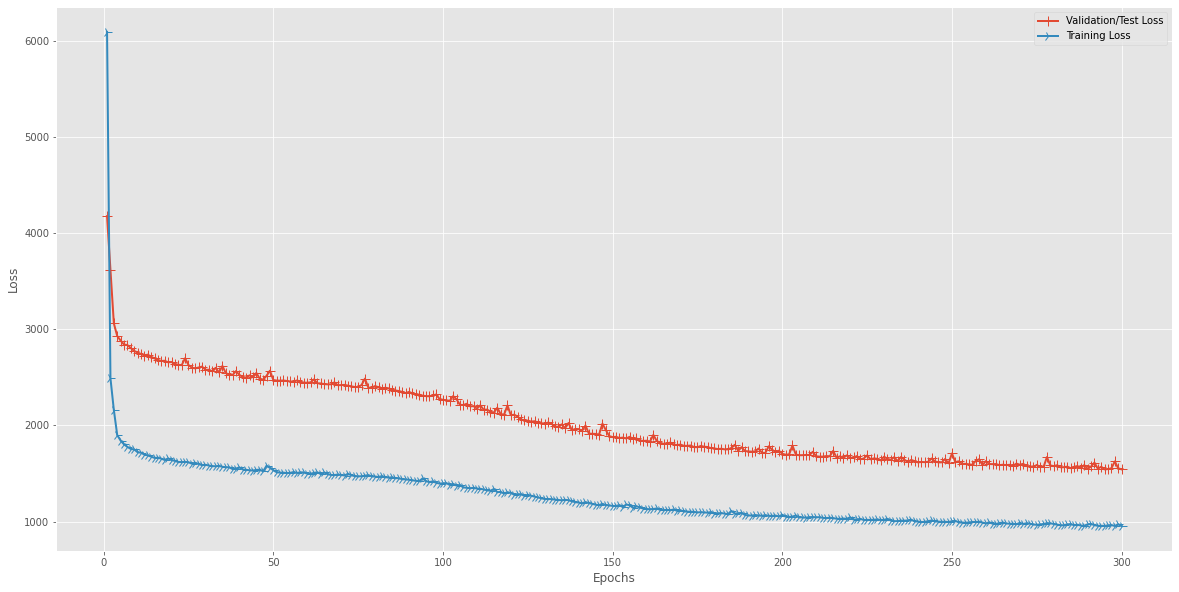

In [34]:
# print(history.history.keys())
# Plotting our loss charts
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.style.use("ggplot")

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label='Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label='Training Loss')
plt.setp(line1, linewidth=2.0, marker = '+', markersize=10.0)
plt.setp(line2, linewidth=2.0, marker = '4', markersize=10.0)
plt.xlabel('Epochs') 
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.savefig('Loss_CAE.png', dpi = 1200)
plt.show()

In [49]:
preds=model.predict(x_train)
# # x_train=x_train.reshape((144, img_shape[0],img_shape[0], 3))
# preds=(k.reshape((144, img_shape[0],img_shape[0], 3))*255.)
# pred=preds[0].astype(np.uint8)

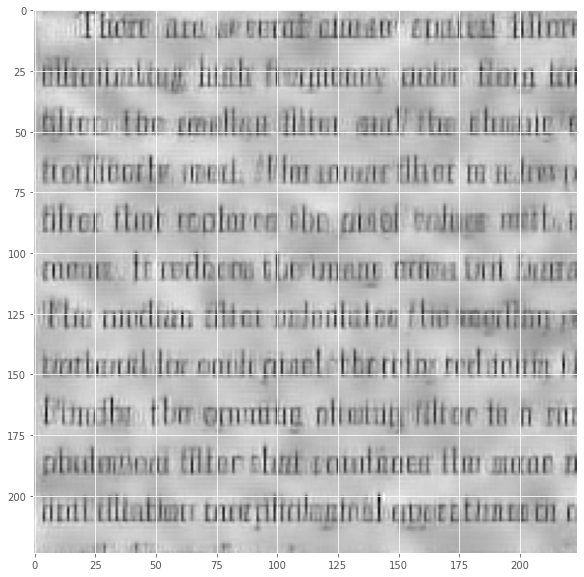

In [58]:
plt.figure(figsize=(25,10))
plt.imshow(np.squeeze(preds[1]),cmap="gray")
# plt.imshow(np.squeeze(x_train[1]),cmap="gray")


In [60]:
loss= model.evaluate(x_test,preds)
print("CAE MSE validation loss:", loss)

5/5 [==============================] - 0s 19ms/step - loss: 1317.0139
CAE MSE validation loss: 1317.013916015625
